**SETUP & INSTALLATION**

In [ ]:
!pip uninstall datasets -y
!pip install 'datasets==3.1.0' --force-reinstall --no-deps

Found existing installation: datasets 3.1.0
Uninstalling datasets-3.1.0:
  Successfully uninstalled datasets-3.1.0
  Using cached datasets-3.1.0-py3-none-any.whl.metadata (20 kB)
Using cached datasets-3.1.0-py3-none-any.whl (480 kB)


In [ ]:
!pip install transformers torch accelerate -q

In [ ]:
import datasets
from datasets import load_dataset
from transformers import AutoTokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json
import re
from tqdm.auto import tqdm

print("\n" + "="*70)
print("LIBRARY VERIFICATION")
print("="*70)
print(f"✓ Datasets version: {datasets.__version__}")
print(f"✓ Python version: 3.10+")
print(f"✓ All libraries imported successfully!")

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


LIBRARY VERIFICATION
✓ Datasets version: 3.1.0
✓ Python version: 3.10+
✓ All libraries imported successfully!


**LOAD XSUM DATASET**

In [ ]:
print("\n" + "="*70)
print("LOADING XSUM DATASET")
print("="*70)
print("This may take a few minutes on first run...\n")

# Load the full dataset (should work now with datasets 3.1.0)
ds = load_dataset("EdinburghNLP/xsum")

print("="*70)
print("✅ DATASET LOADED SUCCESSFULLY!")
print("="*70)
print(f"\nDataset splits: {list(ds.keys())}")
print(f"Training samples: {len(ds['train']):,}")
print(f"Validation samples: {len(ds['validation']):,}")
print(f"Test samples: {len(ds['test']):,}")
print(f"Total samples: {len(ds['train']) + len(ds['validation']) + len(ds['test']):,}")


LOADING XSUM DATASET
This may take a few minutes on first run...



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


default/train/0000.parquet:   0%|          | 0.00/304M [00:00<?, ?B/s]

default/validation/0000.parquet:   0%|          | 0.00/16.7M [00:00<?, ?B/s]

default/test/0000.parquet:   0%|          | 0.00/17.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

✅ DATASET LOADED SUCCESSFULLY!

Dataset splits: ['train', 'validation', 'test']
Training samples: 204,045
Validation samples: 11,332
Test samples: 11,334
Total samples: 226,711


**INITIAL DATA EXPLORATION**

In [ ]:
print("\n" + "=" * 70)
print("EXPLORING DATASET STRUCTURE")
print("=" * 70)

# Examine the first example
print("\n📄 Sample Article-Summary Pair:\n")
sample = ds['train'][0]
print("Fields:", list(sample.keys()))
print("\n" + "-" * 70)
print("DOCUMENT (Article):")
print("-" * 70)
print(sample['document'][:500] + "...")
print("\n" + "-" * 70)
print("SUMMARY:")
print("-" * 70)
print(sample['summary'])
print("\n" + "-" * 70)
print(f"ID: {sample['id']}")

# Show multiple examples
print("\n" + "=" * 70)
print("ADDITIONAL EXAMPLES (First 3 from training set)")
print("=" * 70)

for i in range(3):
    example = ds['train'][i]
    print(f"\n--- Example {i+1} ---")
    print(f"Document preview: {example['document'][:150]}...")
    print(f"Summary: {example['summary']}")


EXPLORING DATASET STRUCTURE

📄 Sample Article-Summary Pair:

Fields: ['document', 'summary', 'id']

----------------------------------------------------------------------
DOCUMENT (Article):
----------------------------------------------------------------------
The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.
Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.
Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct.
Many businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.
First Minister Nicola Sturgeon visited the area to inspect the damage.
The water...

----------------------------------------------------------------------
SUMMARY:
----------------------------------------------------------------------
Clean-up operations are continuing across the Scottish Borders and Dumfries and G

**TEXT LENGTH ANALYSIS**

In [ ]:
print("\n" + "=" * 70)
print("ANALYZING TEXT LENGTHS")
print("=" * 70)

def analyze_lengths(dataset_split, split_name, sample_size=5000):
    """Analyze character and word counts for documents and summaries"""

    print(f"\nAnalyzing {split_name} split (sample: {sample_size})...")

    # Sample for faster analysis
    sample_indices = np.random.choice(len(dataset_split),
                                     min(sample_size, len(dataset_split)),
                                     replace=False)

    doc_char_lengths = []
    sum_char_lengths = []
    doc_word_lengths = []
    sum_word_lengths = []
    doc_sentence_counts = []

    for idx in tqdm(sample_indices, desc=f"Processing {split_name}"):
        item = dataset_split[int(idx)]
        doc = item['document']
        summary = item['summary']

        # Character counts
        doc_char_lengths.append(len(doc))
        sum_char_lengths.append(len(summary))

        # Word counts
        doc_word_lengths.append(len(doc.split()))
        sum_word_lengths.append(len(summary.split()))

        # Sentence counts (rough estimate)
        doc_sentence_counts.append(len(re.split(r'[.!?]+', doc)))

    return {
        'doc_chars': doc_char_lengths,
        'sum_chars': sum_char_lengths,
        'doc_words': doc_word_lengths,
        'sum_words': sum_word_lengths,
        'doc_sentences': doc_sentence_counts
    }


ANALYZING TEXT LENGTHS


In [ ]:
# Analyze training set
train_stats = analyze_lengths(ds['train'], 'train', sample_size=5000)

# Display statistics
print("\n" + "=" * 70)
print("LENGTH STATISTICS (Training Set Sample)")
print("=" * 70)

stats_df = pd.DataFrame({
    'Metric': ['Documents (words)', 'Summaries (words)',
               'Documents (chars)', 'Summaries (chars)',
               'Documents (sentences)'],
    'Mean': [
        np.mean(train_stats['doc_words']),
        np.mean(train_stats['sum_words']),
        np.mean(train_stats['doc_chars']),
        np.mean(train_stats['sum_chars']),
        np.mean(train_stats['doc_sentences'])
    ],
    'Median': [
        np.median(train_stats['doc_words']),
        np.median(train_stats['sum_words']),
        np.median(train_stats['doc_chars']),
        np.median(train_stats['sum_chars']),
        np.median(train_stats['doc_sentences'])
    ],
    'Min': [
        np.min(train_stats['doc_words']),
        np.min(train_stats['sum_words']),
        np.min(train_stats['doc_chars']),
        np.min(train_stats['sum_chars']),
        np.min(train_stats['doc_sentences'])
    ],
    'Max': [
        np.max(train_stats['doc_words']),
        np.max(train_stats['sum_words']),
        np.max(train_stats['doc_chars']),
        np.max(train_stats['sum_chars']),
        np.max(train_stats['doc_sentences'])
    ],
    'Std Dev': [
        np.std(train_stats['doc_words']),
        np.std(train_stats['sum_words']),
        np.std(train_stats['doc_chars']),
        np.std(train_stats['sum_chars']),
        np.std(train_stats['doc_sentences'])
    ]
})

print(stats_df.to_string(index=False))


Analyzing train split (sample: 5000)...


Processing train:   0%|          | 0/5000 [00:00<?, ?it/s]


LENGTH STATISTICS (Training Set Sample)
               Metric      Mean  Median  Min   Max     Std Dev
    Documents (words)  381.7268   299.0    6  4196  305.593174
    Summaries (words)   21.1396    21.0    1    55    5.250877
    Documents (chars) 2249.6594  1763.0   26 23574 1799.103065
    Summaries (chars)  125.4644   127.0    1   342   30.283856
Documents (sentences)   21.0164    16.0    1   269   17.976310


In [ ]:
# Calculate compression ratio
compression_ratio = np.mean(train_stats['doc_words']) / np.mean(train_stats['sum_words'])
print(f"\n📊 Average Compression Ratio: {compression_ratio:.2f}x")
print(f"   (Documents are ~{compression_ratio:.1f} times longer than summaries)")


📊 Average Compression Ratio: 18.06x
   (Documents are ~18.1 times longer than summaries)


**VISUALIZATION OF LENGTH DISTRIBUTIONS**


GENERATING LENGTH DISTRIBUTION PLOTS


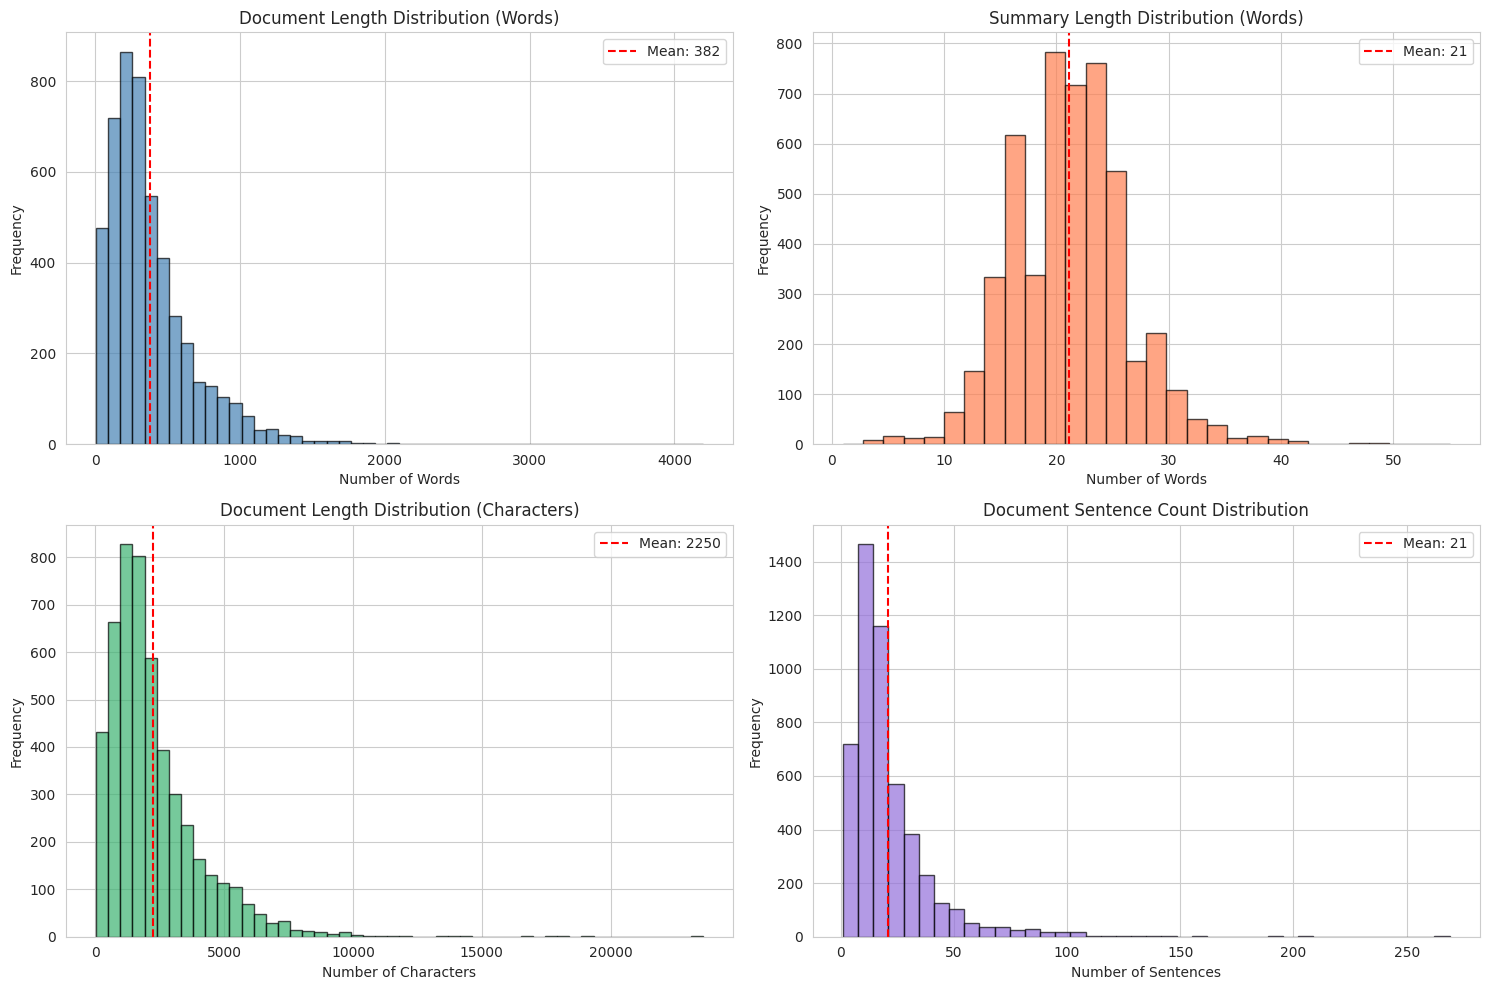

✓ Plots saved as 'xsum_length_distributions.png'


In [ ]:
print("\n" + "=" * 70)
print("GENERATING LENGTH DISTRIBUTION PLOTS")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Document word length distribution
axes[0, 0].hist(train_stats['doc_words'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Number of Words')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Document Length Distribution (Words)')
axes[0, 0].axvline(np.mean(train_stats['doc_words']), color='red',
                    linestyle='--', label=f"Mean: {np.mean(train_stats['doc_words']):.0f}")
axes[0, 0].legend()

# Summary word length distribution
axes[0, 1].hist(train_stats['sum_words'], bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Number of Words')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Summary Length Distribution (Words)')
axes[0, 1].axvline(np.mean(train_stats['sum_words']), color='red',
                    linestyle='--', label=f"Mean: {np.mean(train_stats['sum_words']):.0f}")
axes[0, 1].legend()

# Document character length distribution
axes[1, 0].hist(train_stats['doc_chars'], bins=50, color='mediumseagreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Number of Characters')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Document Length Distribution (Characters)')
axes[1, 0].axvline(np.mean(train_stats['doc_chars']), color='red',
                    linestyle='--', label=f"Mean: {np.mean(train_stats['doc_chars']):.0f}")
axes[1, 0].legend()

# Sentence count distribution
axes[1, 1].hist(train_stats['doc_sentences'], bins=40, color='mediumpurple', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Number of Sentences')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Document Sentence Count Distribution')
axes[1, 1].axvline(np.mean(train_stats['doc_sentences']), color='red',
                    linestyle='--', label=f"Mean: {np.mean(train_stats['doc_sentences']):.0f}")
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('xsum_length_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plots saved as 'xsum_length_distributions.png'")

**DATA QUALITY CHECKS**

In [ ]:
print("\n" + "=" * 70)
print("DATA QUALITY ANALYSIS")
print("=" * 70)

def check_data_quality(dataset_split, split_name, sample_size=10000):
    """Check for data quality issues"""

    print(f"\nChecking {split_name} split...")

    sample_size = min(sample_size, len(dataset_split))

    empty_docs = 0
    empty_sums = 0
    very_short_docs = 0  # < 50 words
    very_short_sums = 0  # < 5 words
    very_long_docs = 0   # > 1000 words
    missing_ids = 0
    special_char_issues = 0

    for i in tqdm(range(sample_size), desc=f"Quality check {split_name}"):
        item = dataset_split[i]
        doc = item['document'].strip()
        summary = item['summary'].strip()

        # Check for empty fields
        if not doc:
            empty_docs += 1
        if not summary:
            empty_sums += 1

        # Check for very short texts
        if len(doc.split()) < 50:
            very_short_docs += 1
        if len(summary.split()) < 5:
            very_short_sums += 1

        # Check for very long documents
        if len(doc.split()) > 1000:
            very_long_docs += 1

        # Check for missing IDs
        if not item['id']:
            missing_ids += 1

        # Check for encoding issues (excessive special characters)
        special_chars = len(re.findall(r'[^\w\s.,!?\-\'"()]', doc))
        if special_chars > len(doc) * 0.05:  # More than 5% special chars
            special_char_issues += 1

    print(f"\n{'='*50}")
    print(f"Quality Report for {split_name.upper()}")
    print(f"{'='*50}")
    print(f"Empty documents: {empty_docs} ({empty_docs/sample_size*100:.2f}%)")
    print(f"Empty summaries: {empty_sums} ({empty_sums/sample_size*100:.2f}%)")
    print(f"Very short documents (<50 words): {very_short_docs} ({very_short_docs/sample_size*100:.2f}%)")
    print(f"Very short summaries (<5 words): {very_short_sums} ({very_short_sums/sample_size*100:.2f}%)")
    print(f"Very long documents (>1000 words): {very_long_docs} ({very_long_docs/sample_size*100:.2f}%)")
    print(f"Missing IDs: {missing_ids} ({missing_ids/sample_size*100:.2f}%)")
    print(f"Potential encoding issues: {special_char_issues} ({special_char_issues/sample_size*100:.2f}%)")

    return {
        'empty_docs': empty_docs,
        'empty_sums': empty_sums,
        'very_short_docs': very_short_docs,
        'very_short_sums': very_short_sums,
        'very_long_docs': very_long_docs,
        'missing_ids': missing_ids,
        'special_char_issues': special_char_issues
    }

# Check quality for all splits
train_quality = check_data_quality(ds['train'], 'train', sample_size=10000)
val_quality = check_data_quality(ds['validation'], 'validation', sample_size=len(ds['validation']))


DATA QUALITY ANALYSIS

Checking train split...


Quality check train:   0%|          | 0/10000 [00:00<?, ?it/s]


Quality Report for TRAIN
Empty documents: 2 (0.02%)
Empty summaries: 0 (0.00%)
Very short documents (<50 words): 147 (1.47%)
Very short summaries (<5 words): 16 (0.16%)
Very long documents (>1000 words): 380 (3.80%)
Missing IDs: 0 (0.00%)
Potential encoding issues: 0 (0.00%)

Checking validation split...


Quality check validation:   0%|          | 0/11332 [00:00<?, ?it/s]


Quality Report for VALIDATION
Empty documents: 5 (0.04%)
Empty summaries: 0 (0.00%)
Very short documents (<50 words): 171 (1.51%)
Very short summaries (<5 words): 15 (0.13%)
Very long documents (>1000 words): 398 (3.51%)
Missing IDs: 0 (0.00%)
Potential encoding issues: 0 (0.00%)


**DATA CLEANING**

In [ ]:
print("\n" + "=" * 70)
print("CLEANING PROBLEMATIC SAMPLES")
print("=" * 70)

def clean_dataset(dataset_split, split_name):
    """Remove samples with quality issues"""

    print(f"\nCleaning {split_name} split...")
    original_size = len(dataset_split)

    def is_valid_sample(example):
        """Check if sample meets quality criteria"""
        doc = example['document'].strip()
        summary = example['summary'].strip()

        # Filter criteria
        has_document = len(doc) > 0
        has_summary = len(summary) > 0
        doc_has_min_words = len(doc.split()) >= 50  # At least 50 words
        sum_has_min_words = len(summary.split()) >= 5  # At least 5 words
        doc_not_too_long = len(doc.split()) <= 1000  # Max 1000 words (will truncate later anyway)

        return (has_document and has_summary and
                doc_has_min_words and sum_has_min_words and
                doc_not_too_long)

    # Apply filtering
    cleaned_dataset = dataset_split.filter(is_valid_sample)

    removed = original_size - len(cleaned_dataset)
    removed_pct = (removed / original_size) * 100

    print(f"✓ {split_name}: {original_size:,} → {len(cleaned_dataset):,} samples")
    print(f"  Removed: {removed} ({removed_pct:.2f}%)")

    return cleaned_dataset

# Clean all splits
print("\nApplying quality filters:")
print("  - Remove empty documents/summaries")
print("  - Remove documents with <50 words")
print("  - Remove summaries with <5 words")
print("  - Remove documents with >1000 words")

ds_cleaned = {}
ds_cleaned['train'] = clean_dataset(ds['train'], 'train')
ds_cleaned['validation'] = clean_dataset(ds['validation'], 'validation')
ds_cleaned['test'] = clean_dataset(ds['test'], 'test')

# Convert back to DatasetDict
from datasets import DatasetDict
ds_cleaned = DatasetDict(ds_cleaned)

print("\n" + "=" * 70)
print("CLEANING SUMMARY")
print("=" * 70)
print(f"Original total samples: {len(ds['train']) + len(ds['validation']) + len(ds['test']):,}")
print(f"Cleaned total samples: {len(ds_cleaned['train']) + len(ds_cleaned['validation']) + len(ds_cleaned['test']):,}")
print(f"Total removed: {(len(ds['train']) + len(ds['validation']) + len(ds['test'])) - (len(ds_cleaned['train']) + len(ds_cleaned['validation']) + len(ds_cleaned['test'])):,}")

# Update ds variable to use cleaned version
ds = ds_cleaned

print("\n✅ Data cleaning complete! Using cleaned dataset for remaining analysis.")

# Verify cleaning worked
print("\n" + "=" * 70)
print("VERIFICATION: Spot Check Cleaned Data")
print("=" * 70)

sample_indices = [0, 100, 500]
for idx in sample_indices:
    sample = ds['train'][idx]
    print(f"\nSample {idx}:")
    print(f"  Document length: {len(sample['document'].split())} words")
    print(f"  Summary length: {len(sample['summary'].split())} words")
    print(f"  Document preview: {sample['document'][:100]}...")
    print(f"  Summary: {sample['summary'][:80]}...")


CLEANING PROBLEMATIC SAMPLES

Applying quality filters:
  - Remove empty documents/summaries
  - Remove documents with <50 words
  - Remove summaries with <5 words
  - Remove documents with >1000 words

Cleaning train split...


Filter:   0%|          | 0/204045 [00:00<?, ? examples/s]

✓ train: 204,045 → 193,104 samples
  Removed: 10941 (5.36%)

Cleaning validation split...


Filter:   0%|          | 0/11332 [00:00<?, ? examples/s]

✓ validation: 11,332 → 10,750 samples
  Removed: 582 (5.14%)

Cleaning test split...


Filter:   0%|          | 0/11334 [00:00<?, ? examples/s]

✓ test: 11,334 → 10,748 samples
  Removed: 586 (5.17%)

CLEANING SUMMARY
Original total samples: 226,711
Cleaned total samples: 214,602
Total removed: 12,109

✅ Data cleaning complete! Using cleaned dataset for remaining analysis.

VERIFICATION: Spot Check Cleaned Data

Sample 0:
  Document length: 400 words
  Summary length: 18 words
  Document preview: The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed....
  Summary: Clean-up operations are continuing across the Scottish Borders and Dumfries and ...

Sample 100:
  Document length: 406 words
  Summary length: 20 words
  Document preview: Assembly Tory leader Andrew RT Davies said although devolved, health was one of the main election is...
  Summary: Labour has been "slashing" the NHS budget in Wales, the Welsh Conservatives have...

Sample 500:
  Document length: 165 words
  Summary length: 19 words
  Document preview: The seventh seeds beat Koreans Kim Gi Jung and Shin Seung Chan 21-1

**TOKENIZATION ANALYSIS WITH PHI-2 TOKENIZER**

In [ ]:
print("\n" + "=" * 70)
print("TOKENIZATION ANALYSIS WITH PHI-2")
print("=" * 70)

print("\nLoading Phi-2 tokenizer...")
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)

# Set padding token if not exists
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print("✓ Set pad_token to eos_token")

print(f"✓ Tokenizer loaded successfully!")
print(f"Vocabulary size: {tokenizer.vocab_size:,}")
print(f"Model max length: {tokenizer.model_max_length:,}")

# Analyze token lengths
def analyze_token_lengths(dataset_split, split_name, sample_size=3000):
    """Analyze token counts for documents and summaries"""

    print(f"\nTokenizing {split_name} split (sample: {sample_size})...")

    sample_size = min(sample_size, len(dataset_split))
    sample_indices = np.random.choice(len(dataset_split), sample_size, replace=False)

    doc_token_lengths = []
    sum_token_lengths = []
    combined_token_lengths = []

    for idx in tqdm(sample_indices, desc=f"Tokenizing {split_name}"):
        item = dataset_split[int(idx)]

        # Tokenize document
        doc_tokens = tokenizer(item['document'], add_special_tokens=False)['input_ids']
        doc_token_lengths.append(len(doc_tokens))

        # Tokenize summary
        sum_tokens = tokenizer(item['summary'], add_special_tokens=False)['input_ids']
        sum_token_lengths.append(len(sum_tokens))

        # Combined length (for input + output during training)
        combined_token_lengths.append(len(doc_tokens) + len(sum_tokens))

    return {
        'doc_tokens': doc_token_lengths,
        'sum_tokens': sum_token_lengths,
        'combined_tokens': combined_token_lengths
    }


TOKENIZATION ANALYSIS WITH PHI-2

Loading Phi-2 tokenizer...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

✓ Set pad_token to eos_token
✓ Tokenizer loaded successfully!
Vocabulary size: 50,257
Model max length: 2,048


In [ ]:
# Analyze tokenization
token_stats = analyze_token_lengths(ds['train'], 'train', sample_size=3000)

print("\n" + "=" * 70)
print("TOKEN LENGTH STATISTICS")
print("=" * 70)

token_stats_df = pd.DataFrame({
    'Metric': ['Document tokens', 'Summary tokens', 'Combined (doc+sum)'],
    'Mean': [
        np.mean(token_stats['doc_tokens']),
        np.mean(token_stats['sum_tokens']),
        np.mean(token_stats['combined_tokens'])
    ],
    'Median': [
        np.median(token_stats['doc_tokens']),
        np.median(token_stats['sum_tokens']),
        np.median(token_stats['combined_tokens'])
    ],
    'P95': [
        np.percentile(token_stats['doc_tokens'], 95),
        np.percentile(token_stats['sum_tokens'], 95),
        np.percentile(token_stats['combined_tokens'], 95)
    ],
    'P99': [
        np.percentile(token_stats['doc_tokens'], 99),
        np.percentile(token_stats['sum_tokens'], 99),
        np.percentile(token_stats['combined_tokens'], 99)
    ],
    'Max': [
        np.max(token_stats['doc_tokens']),
        np.max(token_stats['sum_tokens']),
        np.max(token_stats['combined_tokens'])
    ]
})

print(token_stats_df.to_string(index=False))

# Phi-2 context window analysis
PHI2_MAX_LENGTH = 2048
exceeds_context = sum(1 for x in token_stats['combined_tokens'] if x > PHI2_MAX_LENGTH)
print(f"\n⚠️  Samples exceeding Phi-2's 2048 token limit: {exceeds_context} ({exceeds_context/len(token_stats['combined_tokens'])*100:.2f}%)")

# Determine appropriate max lengths
recommended_doc_length = int(np.percentile(token_stats['doc_tokens'], 95))
recommended_sum_length = int(np.percentile(token_stats['sum_tokens'], 99))

print(f"\n📋 RECOMMENDED MAX LENGTHS FOR TRAINING:")
print(f"   Document max length: {recommended_doc_length} tokens (covers 95% of data)")
print(f"   Summary max length: {recommended_sum_length} tokens (covers 99% of data)")
print(f"   Total: {recommended_doc_length + recommended_sum_length} tokens (within 2048 limit)")


Tokenizing train split (sample: 3000)...


Tokenizing train:   0%|          | 0/3000 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2711 > 2048). Running this sequence through the model will result in indexing errors



TOKEN LENGTH STATISTICS
            Metric       Mean  Median     P95     P99  Max
   Document tokens 450.014333   382.0 1031.05 1223.07 2711
    Summary tokens  26.260333    26.0   37.00   45.00   81
Combined (doc+sum) 476.274667   409.5 1063.05 1252.01 2765

⚠️  Samples exceeding Phi-2's 2048 token limit: 1 (0.03%)

📋 RECOMMENDED MAX LENGTHS FOR TRAINING:
   Document max length: 1031 tokens (covers 95% of data)
   Summary max length: 45 tokens (covers 99% of data)
   Total: 1076 tokens (within 2048 limit)


**ABSTRACTIVENESS ANALYSIS**

In [ ]:
print("\n" + "=" * 70)
print("ABSTRACTIVENESS ANALYSIS")
print("=" * 70)
print("Measuring novel n-grams in summaries vs documents...")

def calculate_novel_ngrams(dataset_split, sample_size=1000):
    """Calculate percentage of novel n-grams in summaries"""

    sample_size = min(sample_size, len(dataset_split))
    sample_indices = np.random.choice(len(dataset_split), sample_size, replace=False)

    novel_unigrams = []
    novel_bigrams = []
    novel_trigrams = []

    for idx in tqdm(sample_indices, desc="Analyzing abstractiveness"):
        item = dataset_split[int(idx)]

        doc_words = item['document'].lower().split()
        sum_words = item['summary'].lower().split()

        # Unigrams
        doc_unigrams = set(doc_words)
        sum_unigrams = sum_words
        novel_uni = sum(1 for word in sum_unigrams if word not in doc_unigrams)
        novel_unigrams.append(novel_uni / len(sum_unigrams) if sum_unigrams else 0)

        # Bigrams
        doc_bigrams = set(zip(doc_words[:-1], doc_words[1:]))
        sum_bigrams = list(zip(sum_words[:-1], sum_words[1:]))
        novel_bi = sum(1 for bg in sum_bigrams if bg not in doc_bigrams)
        novel_bigrams.append(novel_bi / len(sum_bigrams) if sum_bigrams else 0)

        # Trigrams
        doc_trigrams = set(zip(doc_words[:-2], doc_words[1:-1], doc_words[2:]))
        sum_trigrams = list(zip(sum_words[:-2], sum_words[1:-1], sum_words[2:]))
        novel_tri = sum(1 for tg in sum_trigrams if tg not in doc_trigrams)
        novel_trigrams.append(novel_tri / len(sum_trigrams) if sum_trigrams else 0)

    return {
        'unigrams': np.mean(novel_unigrams) * 100,
        'bigrams': np.mean(novel_bigrams) * 100,
        'trigrams': np.mean(novel_trigrams) * 100
    }

abstractiveness = calculate_novel_ngrams(ds['train'], sample_size=1000)

print(f"\n📊 NOVEL N-GRAMS IN SUMMARIES:")
print(f"   Novel unigrams: {abstractiveness['unigrams']:.1f}%")
print(f"   Novel bigrams: {abstractiveness['bigrams']:.1f}%")
print(f"   Novel trigrams: {abstractiveness['trigrams']:.1f}%")
print(f"\n✓ High percentage indicates highly abstractive summaries (not extractive)")


ABSTRACTIVENESS ANALYSIS
Measuring novel n-grams in summaries vs documents...


Analyzing abstractiveness:   0%|          | 0/1000 [00:00<?, ?it/s]


📊 NOVEL N-GRAMS IN SUMMARIES:
   Novel unigrams: 42.7%
   Novel bigrams: 86.5%
   Novel trigrams: 96.5%

✓ High percentage indicates highly abstractive summaries (not extractive)


**CREATE WORKING SUBSET FOR EXPERIMENTATION**

In [ ]:
print("\n" + "=" * 70)
print("CREATING SMALLER SUBSET FOR FAST EXPERIMENTATION")
print("=" * 70)

# Create a smaller subset for quick experimentation
train_subset = ds['train'].shuffle(seed=42).select(range(10000))
val_subset = ds['validation'].shuffle(seed=42).select(range(1000))
test_subset = ds['test'].shuffle(seed=42).select(range(1000))

print(f"✓ Created subsets:")
print(f"   Training: {len(train_subset):,} samples")
print(f"   Validation: {len(val_subset):,} samples")
print(f"   Test: {len(test_subset):,} samples")


CREATING SMALLER SUBSET FOR FAST EXPERIMENTATION
✓ Created subsets:
   Training: 10,000 samples
   Validation: 1,000 samples
   Test: 1,000 samples


**SAVE PREPROCESSING METADATA**

In [ ]:
print("\n" + "=" * 70)
print("SAVING PROCESSED DATA")
print("=" * 70)

# Option 1: Save to Google Drive (RECOMMENDED)
from google.colab import drive
drive.mount('/content/drive')

# Create directory for your project
import os
save_dir = '/content/drive/MyDrive/DL_FinalTask_XSum'
os.makedirs(save_dir, exist_ok=True)
print(f"✓ Created project directory: {save_dir}")

# Save the full dataset splits (already loaded, just save references)
print("\nSaving dataset to disk...")
ds.save_to_disk(f'{save_dir}/xsum_full_dataset')
print(f"✓ Full dataset saved to {save_dir}/xsum_full_dataset")

# Save the smaller subsets
from datasets import DatasetDict
subset_dict = DatasetDict({
    'train': train_subset,
    'validation': val_subset,
    'test': test_subset
})
subset_dict.save_to_disk(f'{save_dir}/xsum_subset_dataset')
print(f"✓ Subset dataset saved to {save_dir}/xsum_subset_dataset")

# Save preprocessing metadata
import shutil
shutil.copy('preprocessing_metadata.json', f'{save_dir}/preprocessing_metadata.json')
print(f"✓ Metadata saved to {save_dir}/preprocessing_metadata.json")

# Save statistics for reference
statistics_data = {
    'length_stats': {
        'doc_words': train_stats['doc_words'][:1000],  # Sample for size
        'sum_words': train_stats['sum_words'][:1000],
        'doc_tokens': token_stats['doc_tokens'][:1000],
        'sum_tokens': token_stats['sum_tokens'][:1000]
    },
    'recommendations': {
        'max_doc_length': recommended_doc_length,
        'max_sum_length': recommended_sum_length
    }
}

with open(f'{save_dir}/statistics.json', 'w') as f:
    json.dump(statistics_data, f, indent=2)
print(f"✓ Statistics saved to {save_dir}/statistics.json")

print("\n" + "=" * 70)
print("ALL DATA SAVED SUCCESSFULLY!")
print("=" * 70)
print(f"\nYour data is saved in: {save_dir}")
print("\nFiles created:")
print("  📁 xsum_full_dataset/        - Full XSum dataset (204K samples)")
print("  📁 xsum_subset_dataset/      - Smaller subset (10K train, 1K val/test)")
print("  📄 preprocessing_metadata.json - Dataset statistics and config")
print("  📄 statistics.json           - Length analysis data")


SAVING PROCESSED DATA
Mounted at /content/drive
✓ Created project directory: /content/drive/MyDrive/DL_FinalTask_XSum

Saving dataset to disk...


Saving the dataset (0/1 shards):   0%|          | 0/193104 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10750 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10748 [00:00<?, ? examples/s]

✓ Full dataset saved to /content/drive/MyDrive/DL_FinalTask_XSum/xsum_full_dataset


Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

✓ Subset dataset saved to /content/drive/MyDrive/DL_FinalTask_XSum/xsum_subset_dataset
✓ Metadata saved to /content/drive/MyDrive/DL_FinalTask_XSum/preprocessing_metadata.json
✓ Statistics saved to /content/drive/MyDrive/DL_FinalTask_XSum/statistics.json

ALL DATA SAVED SUCCESSFULLY!

Your data is saved in: /content/drive/MyDrive/DL_FinalTask_XSum

Files created:
  📁 xsum_full_dataset/        - Full XSum dataset (204K samples)
  📁 xsum_subset_dataset/      - Smaller subset (10K train, 1K val/test)
  📄 preprocessing_metadata.json - Dataset statistics and config
  📄 statistics.json           - Length analysis data
